# Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project. Before starting, follow these simple instructions: 

1.   Go to https://drive.google.com/
2.   Create a folder named 'Data' in 'MyDrive': On the left, click 'New' > 'Folder', enter the name 'Data', and click 'create'
3.   Open the 'Data' folder and create a folder named 'MLEndLS'.

Let's start by loading a few useful Python libraries and mounting our personal Google Drive storage system (i.e. making it available, so that Colab can access it).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

In [3]:
sample_path = 'MLEndLS/*.wav'
files = glob.glob(sample_path)
len(files)

2500

This figure (100) corresponds to the number of **items** or **samples** in our dataset. Let's listen to some random audio files:

In [3]:
for _ in range(5):
  n = np.random.randint(2500)
  display(ipd.Audio(files[n]))

Can you recognise the filming spot? What can you say about the acoustic environment?

The MLEndLS Dataset is a collection of samples described by 5 attributes:
- Audio
- Area
- Spot
- Whether indoor or outdoor
- Participant

Upload the CSV file 'MLEndLS_Sample.csv'. Then run the next cell to load it into a Pandas DataFrame and print its contents.


In [7]:
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 
MLENDLS_df

area       spot   in_out Participant
file_id                                             
0001.wav     british     street  outdoor        S151
0002.wav  kensington   dinosaur   indoor        S127
0003.wav      campus     square  outdoor         S18
0004.wav  kensington     hintze   indoor        S179
0005.wav      campus     square  outdoor        S176
...              ...        ...      ...         ...
2496.wav     westend  trafalgar  outdoor        S151
2497.wav      campus     square  outdoor          S6
2498.wav     westend   national   indoor         S96
2499.wav     british     room12   indoor         S73
2500.wav     british     room12   indoor         S58

[2500 rows x 4 columns]

The audio attribute is a complex one and cannot be directly inserted in a DataFrame structure. Instead, we have the name of the corresponding audio files, e.g. '3086.wav', which in our case are stored in the '/content/drive/MyDrive/Data/MLEndLS/sample/MLEndLS_Sample/' folder. 

The next cell prints the contents of the folder that stores our sample audio files. You can see that the names of the WAV files correspond to one of the `file_id` entries in the `MLEndLS_df` DataFrame.

In [5]:
for file in files[0:10]:
  print(file.split('/')[-1])

1864.wav
0970.wav
2113.wav
0212.wav
0239.wav
1994.wav
1884.wav
0506.wav
1704.wav
1214.wav


# Feature extraction : Pitch

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D temporal grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

[[ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
  -6.5048743e-04+0.0000000e+00j ... -1.1235412e+00+0.0000000e+00j
  -1.4990327e+00+0.0000000e+00j  6.0175781e+00+0.0000000e+00j]
 [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
  -6.3495943e-04-1.4059136e-04j ... -2.8519663e-01-5.1478348e+00j
   5.8963265e+00+4.7394176e+00j -8.0502882e+00+2.8569024e+00j]
 [ 0.0000000e+00-0.0000000e+00j  0.0000000e+00-0.0000000e+00j
  -5.8816717e-04-2.7484799e-04j ...  4.9578981e+00+3.7141550e+00j
  -7.6592155e+00-4.5014052e+00j  7.5936055e+00-2.3891087e-01j]
 ...
 [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
   1.4489968e-06+3.9615607e-06j ...  2.7129538e-02-1.2332445e-02j
   5.0506386e-04-4.3873771e-04j -8.8958042e-03+7.8157727e-03j]
 [ 0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j
  -2.0792520e-06+3.1730651e-06j ... -6.2507470e-03-2.9453335e-02j
   4.5720811e-04-2.0481531e-04j -4.1147987e-03-1.0990497e-02j]
 [ 0.0000000e+00+0.0000000e+00j  0.00000

ValueError: x and y must have same first dimension, but have shapes (321930,) and (1025, 629)

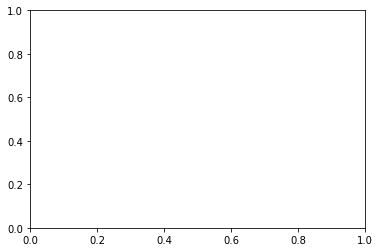

In [13]:
def getPitch1(x,fs,winLen=0.02):
    #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
    times = librosa.times_like(f0)
    print(times[-1])
    return f0,voiced_flag

n=10
fs = None # Sampling frequency
x, fs = librosa.load(files[n],sr=fs)
ft = librosa.stft(x)

print(ft)
t = np.arange(len(x))/fs

f, v = getPitch1(x,fs)
# print(x)
plt.plot(t,ft)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
# print(x)
plt.plot(v)
# plt.xlabel('time (sec)')
# plt.ylabel('amplitude')


plt.show()

display(ipd.Audio(files[n]))

Can you tell whether you are listening to an indoors or outdoors location? Does it agree with the values shown in the ``` MLENDLS_df ``` dataframe? Let's check it:
 

In [88]:
MLENDLS_df.loc[files[n].split('/')[-1]]

area            campus
spot           library
in_out         outdoor
Participant        S72
Name: 1657.wav, dtype: object

Note that we are using the name of the audio file as the index in the Pandas DataFrame. By changing the value of `n` in the previous cell, you can listen to other examples. If you are doing this during one of our lab sessions, please make sure that your mic is muted!

Exactly, how complex is an audio signal? Let's start by looking at the number of samples (i.e. time series samples) in one of our audio files:

In [10]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 302085 samples


If we are using a raw audio signal as the input of a machine learning model, we will be operating in a predictor space consisting of hundreds of thousands of dimensions. Compare this figure with the number of items (i.e. recordings) that we have. Do we have enough samples to train a model that takes one of these audio signals as an input?

One approach to deal with this huge dimensionality is to extract a few features from our signals and use these features as predictors instead. In this notebook we will use four audio features, namely:


1.   Power.
2.   Pitch - mean.
3.   Pitch - standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal (do not worry if you do not know what it is, but feel free to read about it!).

In [8]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  times = librosa.times_like(f0)
  return f0,voiced_flag

Let's consider the problem of determining whether the filming spot is indoors or outdoors. Then next cell defines a function that takes a collection of audio files together with a CSV file and creates a NumPy array containing the 4 audio features used as predictors (`X`) and a binary label (`y`) that indicates whether the recording is indoors (`y=1`) or outdoors (`y=0`).

In [9]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y,new_files =[],[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]

    yi = labels_file.loc[fileID]['in_out']=='indoor'

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    f0, voiced_flag = None, None
    
    if scale_audio: x = x/np.max(np.abs(x))
        
    try:
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)
    except:
        print(file_name)
        continue

    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)
    new_files.append(file)

  return np.array(X),np.array(y),new_files

Let's apply `getXy` to the subsample and obtain the NumPy predictor array (`X`) and a binary label (`y`). This could take a while, as we are processing each of the 100 audio signals. 

In [10]:
X,y,new_files = getXy(files[0:], labels_file=MLENDLS_df, scale_audio=True, onlySingleDigit=True)

  7%|██▋                                     | 165/2500 [03:38<47:45,  1.23s/it]/tmp/ipykernel_125499/1195346667.py:13: RuntimeWarning: invalid value encountered in divide
  if scale_audio: x = x/np.max(np.abs(x))


2206.wav


 92%|████████████████████████████████████   | 2310/2500 [49:33<04:10,  1.32s/it]

0033.wav


100%|███████████████████████████████████████| 2500/2500 [53:19<00:00,  1.28s/it]


The next cell shows the shape of `X` and `y` and prints the labels vector `y`:

In [ ]:
X_backup = X
y_backup = y

In [25]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (2495, 4)
The shape of y is (2495,)
The labels vector is [False  True  True ... False False False]


As you can see, we have 100 items consisting of 4 features (stored in `X`) and one binary label (stored in `y`). Is our dataset balanced? Let's have a look:

In [41]:
print(' The number of indoor recordings is ', np.count_nonzero(y))
print(' The number of outdoor recordings is ', y.size - np.count_nonzero(y))

 The number of indoor recordings is  1181
 The number of outdoor recordings is  1317


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

n=5

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.labels_[n])

display(ipd.Audio(new_files[n]))

In [ ]:
a, fs = librosa.load(files[n],sr=None)    

S = np.abs(librosa.stft(a))
S = S[10:512,:]
print(S.shape)
S = librosa.amplitude_to_db(S, ref=np.min)
fig, ax = plt.subplots()
img = librosa.display.specshow(S, y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
plt.show()


# Modeling: Support Vector Machines

Let's build a support vector machine (SVM) model for the predictive task of identifying the type of filming spot (indoors/outdoors) using the dataset that we have just created.

We will use the SVM method provided by scikit-learn and will split the dataset defined by X and y into a training set and a validation set.

In [36]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1996, 4), (499, 4), (1996,), (499,))

Can you identify the number of items in the training and validation sets?

Let's now fit an SVM model and print both the training accuracty and validation accuracy.


In [37]:
model  = svm.SVC(C=1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.5506012024048096
Validation  Accuracy 0.5090180360721442
The support vectors are (1901, 4)


Compare the training and validation accuracies. Is our model overfitting, underfitting, performing well? What do you think the accuracy of a random classifier would be?

Let's normalise the predictors, to see if the performance improves.


In [39]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC()
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.5971943887775552
Validation  Accuracy 0.5651302605210421
The support vectors are (1827, 4)


Do you think we have obtained a better solution?

What machine learning pipeline have we implemented for each solution? Feel free to try other machine learning models available in scikit, it's very easy!